In [67]:
#Imports
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import joblib


### Load the data

In [3]:

df = pd.read_csv("../data/healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Data Exploration

In [4]:
print(f'Shape: {df.shape}')
print(f'Columns: {list(df.columns)}')

Shape: (5110, 12)
Columns: ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']


In [5]:
#Check for duplicates
if len(set(df['id'])) == df.shape[0]:
    print("No duplicates")

No duplicates


<Axes: xlabel='stroke', ylabel='Count'>

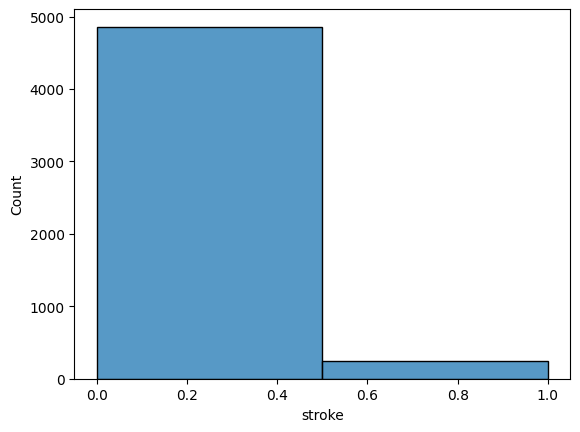

In [6]:
sns.histplot(data= df, x="stroke", bins=2)

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


In [8]:
for col in ['gender','hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    print(f"Unique values in column {col} are {set(df[col])}")

Unique values in column gender are {'Male', 'Other', 'Female'}
Unique values in column hypertension are {0, 1}
Unique values in column heart_disease are {0, 1}
Unique values in column ever_married are {'Yes', 'No'}
Unique values in column work_type are {'Self-employed', 'children', 'Never_worked', 'Private', 'Govt_job'}
Unique values in column Residence_type are {'Urban', 'Rural'}
Unique values in column smoking_status are {'Unknown', 'never smoked', 'formerly smoked', 'smokes'}


### Feature engineering

In [9]:
def categorize_glucose_level(glucose):
    if glucose < 100:
        return 'Normal'
    elif 100 <= glucose < 126:
        return 'Prediabetes'
    else:
        return 'Diabetes'
    

def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 24.9:
        return 'Normal weight'
    elif 25 <= bmi < 29.9:
        return 'Overweight'
    else:
        return 'Obesity'

In [10]:
df = df.drop('id', axis=1)

# Drop Gender = Other
df.drop(df[df.gender == 'Other'].index, inplace=True)
df['gender'] = df['gender'].replace({'Female': 1, 'Male':0})


# Fill bmi
df['bmi'].fillna((df['bmi'].mean()), inplace=True)
df['bmi_cat'] = df['bmi'].apply(categorize_bmi)
df = df.drop('bmi', axis=1)

df['glucose_cat'] = df['avg_glucose_level'].apply(categorize_glucose_level)
df = df.drop('avg_glucose_level', axis=1)

df['ever_married'] = df['ever_married'].replace({'Yes': 1, 'No':0})
df['Residence_type'] = df['Residence_type'].replace({'Urban': 1, 'Rural':0})

df['smoking_status'] = df['smoking_status'].replace({'smokes': 1, 'formerly smoked': 1, 'never smoked':0})
# Drop unknown smoking status
df.drop(df[df.smoking_status == 'Unknown'].index, inplace=True)

Text(0, 0.5, 'Stroke Rate')

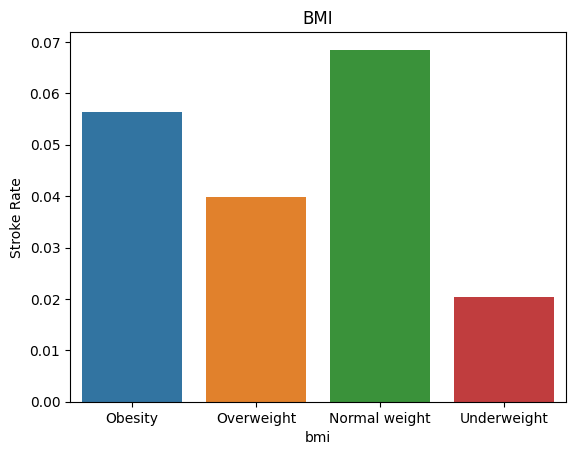

In [11]:
sns.barplot(x = df.bmi_cat.unique() ,
            y = [df[df['bmi_cat'] == "Obesity"].stroke.mean() ,
                df[df['bmi_cat'] == 'Normal weight'].stroke.mean() ,
                df[df['bmi_cat'] == 'Overweight'].stroke.mean() ,
                df[df['bmi_cat'] == "Underweight"].stroke.mean() ])
plt.title('BMI')
plt.xlabel('bmi')
plt.ylabel('Stroke Rate')

In [72]:
categorical_features = ['gender', 'work_type', 'Residence_type', 'smoking_status', 'bmi_cat', 'glucose_cat']
numerical_features = ['age']

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Define target and features
X = df.drop('stroke', axis=1)
y = df['stroke']

### Split training and testing data

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)

### Models

In [78]:
models = {
    "Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    "Logistic Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000))
    ]),
    "AdaBoost": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', AdaBoostClassifier(random_state=42))
    ]),
    "XGBoost": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(eval_metric='logloss'))
    ])
}


# Create a function to train and evaluate models
def train_and_evaluate(models, X, y, X_train, y_train, X_test, y_test):
    cross_val = {}
    conf_mat={}
    results = {}
    for name, model in models.items():
        # Training
        model.fit(X_train, y_train)
        # Prediction
        y_pred = model.predict(X_test)
        # Evaluation
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
        cross_val[name] = cross_val_score(model, X, y, cv=5, scoring='accuracy')
        conf_mat[name] = confusion_matrix(y_test, y_pred)
        # Save model
        joblib.dump(model, f"../model/{name}_model.pkl")
    return results, cross_val, conf_mat

# Train models
model_results, cross_val, conf_mat = train_and_evaluate(models, X, y, X_train, y_train, X_test, y_test)
print(model_results)


{'Random Forest': 0.9214953271028037, 'Logistic Regression': 0.9439252336448598, 'AdaBoost': 0.9439252336448598, 'XGBoost': 0.922429906542056}


In [79]:
cross_val

{'Random Forest': array([0.91023843, 0.92426367, 0.91725105, 0.92987377, 0.91304348]),
 'Logistic Regression': array([0.94249649, 0.94249649, 0.94389902, 0.94389902, 0.94389902]),
 'AdaBoost': array([0.94249649, 0.94249649, 0.94389902, 0.94389902, 0.94389902]),
 'XGBoost': array([0.9256662 , 0.92145863, 0.91725105, 0.92847125, 0.92706872])}